## Setup

In [1]:
import pandas as pd
from tensorflow import keras as ks
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Input, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, Flatten, RepeatVector
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad
from tensorflow.keras.callbacks import EarlyStopping 
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer 
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.metrics import RootMeanSquaredError
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

# Hack in order to make dictionary entries accessible as attributes (e.g. parameters.parameter)
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 18, 8
ks.backend.clear_session()

# Hyperparameter tuning

In [2]:
# features: "air_temperature", "relative_humidity", "rainfall", "wind_speed", "wind_direction", "tide_obs", "tide_pred", "hour"
hyperparams = AttrDict({
    "num_of_epochs": 300,
    "learning_rate": 0.005,
    "batch_size": 30,
    "loss_function": "mse",
    "earlystopping_patience": 12,
    "look_back": 18,
    "look_back_skip": 2,
    "optimizer": Adagrad,
    "features": ["air_temperature", "hour", "relative_humidity", "windx", "windy"],
})

## Dataset and preprocessing

In [3]:
# read dataset to pandas DataFrame
dataset = pd.read_table(
    #'/kaggle/input/badetemperaturer/badetemperaturer.csv', 
    #'/kaggle/input/korsvika/korsvika_water_air_hum.csv',
    '/kaggle/input/korsvika-multivariate/interpolated_data-duplicates_removed.csv',
    delimiter=",", 
    decimal=".", 
    dtype=np.float64, 
    parse_dates=["time"],
    index_col="time"
)

# For inspiration:
# https://www.tensorflow.org/tutorials/structured_data/time_series#feature_engineering

dataset["timestamp"] = dataset.index.values.astype("int64") / 1e9
dataset["hour"] = np.sin(2*np.pi * dataset["timestamp"]/(24*60*60)) # sine-like signal
dataset["year"] = np.sin(2*np.pi * dataset["timestamp"]/(365*24*60*60))

dataset["month"] = dataset.index.month.values.astype("int64")

# Engineer wind
dataset["windx"] = dataset["wind_speed"] * np.cos(2*np.pi * dataset["wind_direction"]/360)
dataset["windy"] = dataset["wind_speed"] * np.sin(2*np.pi * dataset["wind_direction"]/360)

# Remove indoor winter warnings
#dataset = dataset[:10081]

# Use data from summer season only
dataset = dataset[dataset.index.month.isin([4,5,6,7,8,9,10,11])]

index_between_years = 1
while index_between_years < dataset.shape[0] and dataset.index[index_between_years].year == dataset.index[index_between_years-1].year: 
    index_between_years += 1    
validation_data = dataset[:index_between_years]
training_data = dataset[index_between_years:]

# Skip every 2nd row to match weather API and use every 2nd row for validation data
#training_data = dataset2020.iloc[::2, :]
#validation_data = dataset2019.iloc[1::2, :]

# Scale values for training
scaler = MinMaxScaler(feature_range=(0, 1))
training_data = pd.DataFrame(scaler.fit_transform(training_data),columns = dataset.columns)
validation_data = pd.DataFrame(scaler.transform(validation_data),columns = dataset.columns)

# Plotting
Plotting raw data over a period, in addition to plotting air temperatures over water temperatures

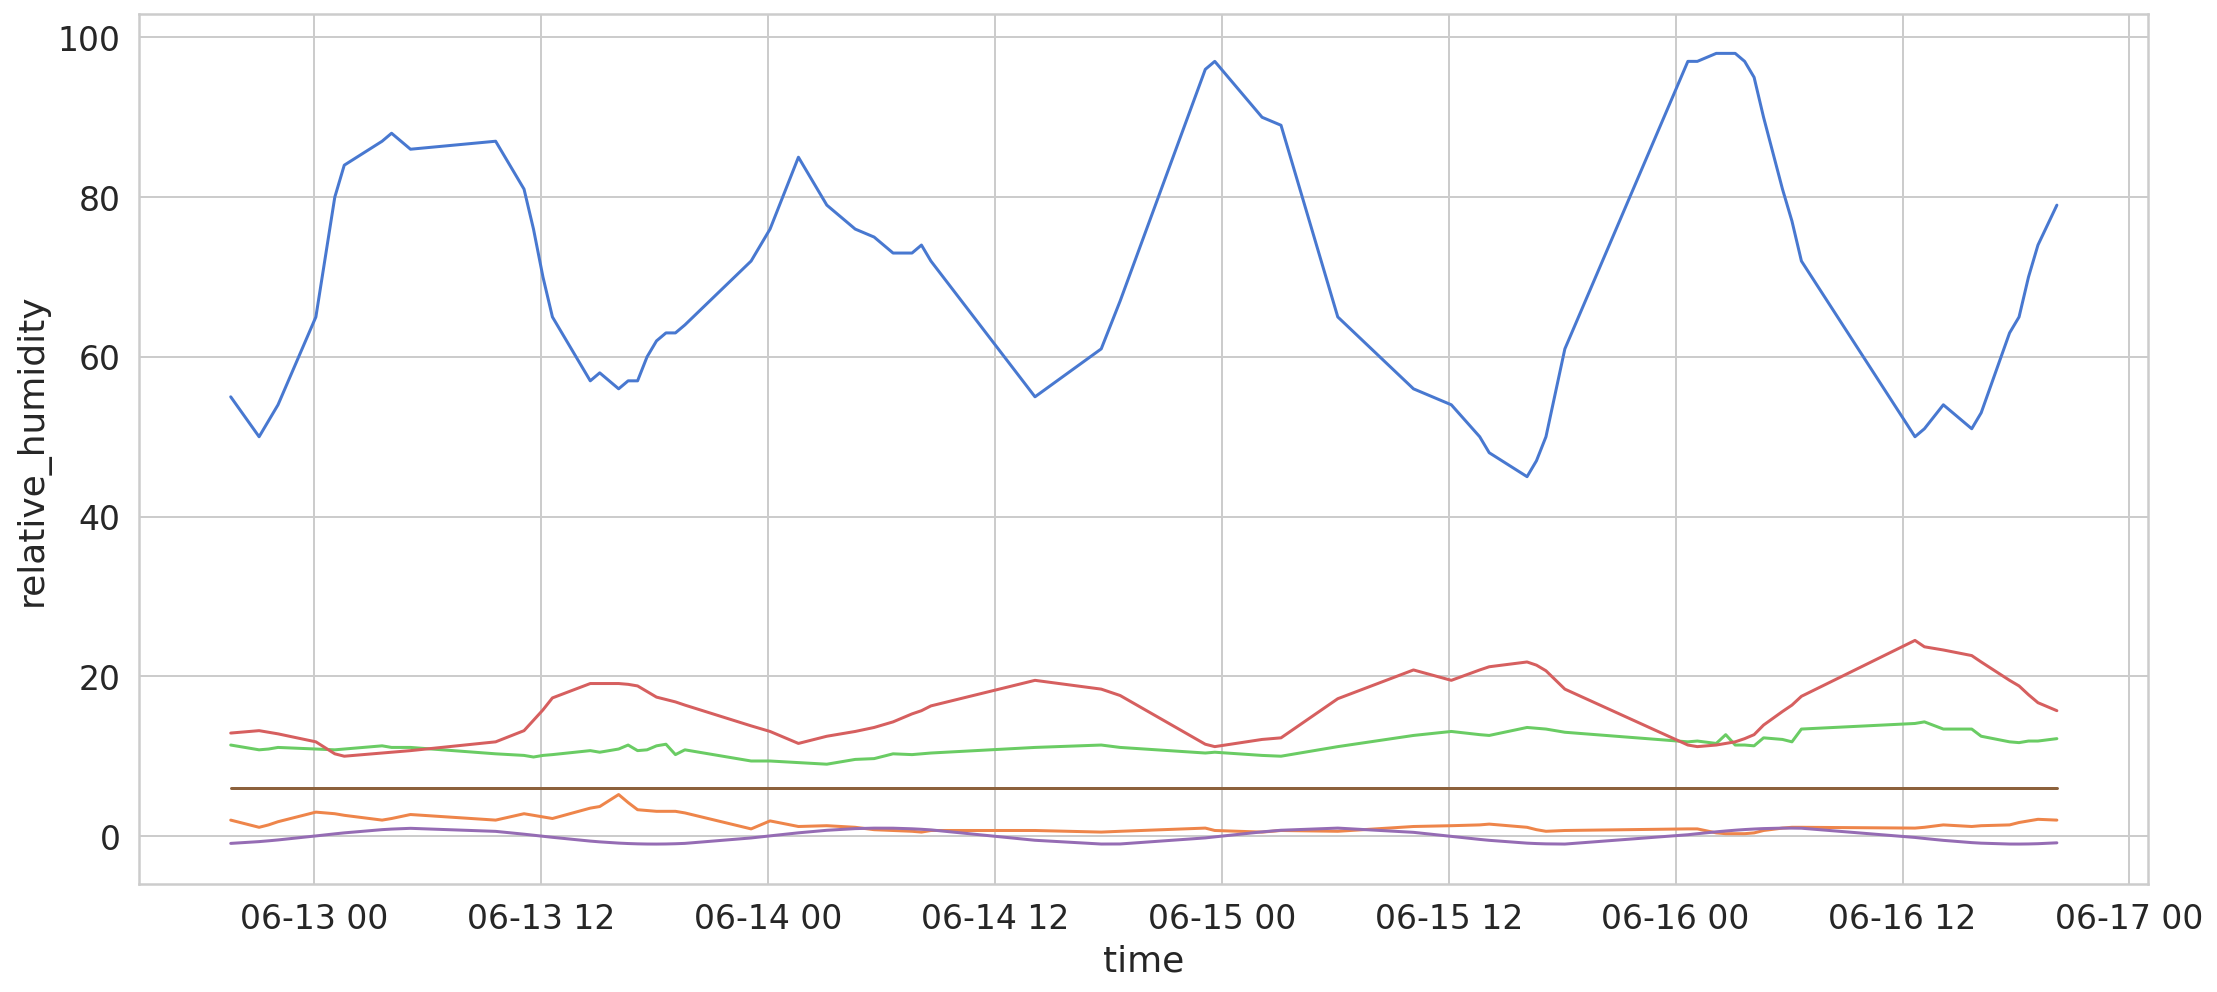

In [4]:
# Plot all data over (about) three days
dataset_sample = dataset.iloc[:72]

sns.lineplot(x=dataset_sample.index, y="relative_humidity", data=dataset_sample);
#sns.lineplot(x=dataset_sample.index, y="rainfall", data=dataset_sample);
sns.lineplot(x=dataset_sample.index, y="wind_speed", data=dataset_sample);
#sns.lineplot(x=dataset_sample.index, y="wind_direction", data=dataset_sample);
#sns.lineplot(x=dataset_sample.index, y="tide_obs", data=dataset_sample);
#sns.lineplot(x=dataset_sample.index, y="tide_pred", data=dataset_sample);
sns.lineplot(x=dataset_sample.index, y="water_temperature", data=dataset_sample);
sns.lineplot(x=dataset_sample.index, y="air_temperature", data=dataset_sample);
sns.lineplot(x=dataset_sample.index, y="hour", data=dataset_sample);
sns.lineplot(x=dataset_sample.index, y="month", data=dataset_sample);

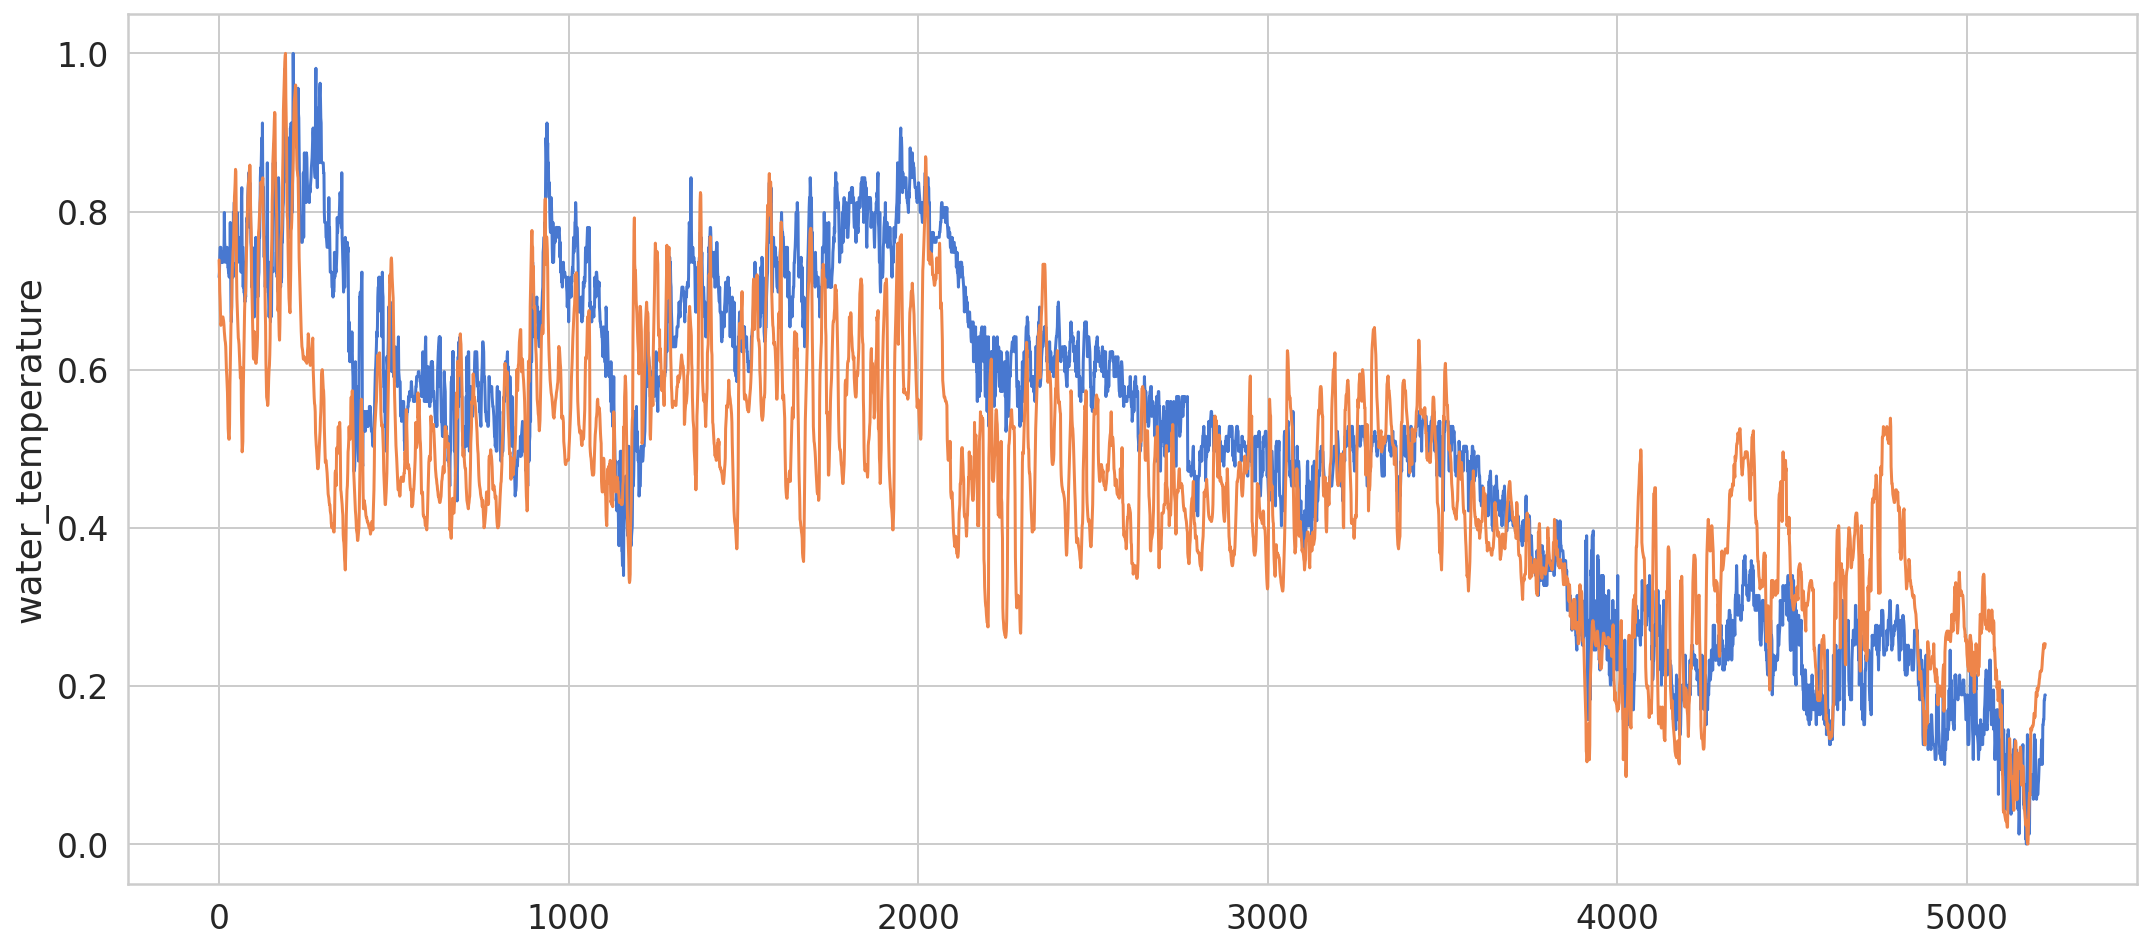

In [5]:
sns.lineplot(x=training_data.index, y="water_temperature", data=training_data);
sns.lineplot(x=training_data.index, y="air_temperature", data=training_data);

# Split data and convert to time series

In [6]:
trainx = training_data[hyperparams.features].values
trainy = training_data["water_temperature"].values

validx = validation_data[hyperparams.features].values
validy = validation_data["water_temperature"].values

train_time_plot = training_data.index.values
valid_time_plot = validation_data.index.values

# Convert using sliding window, like in https://datascience.stackexchange.com/questions/27533/keras-lstm-with-1d-time-series/27535#27535
def step_series(x, y, t, window_size, skip=1):
    x_stepped = np.empty((x.shape[0]-window_size*skip, window_size, x.shape[1]))
    y_stepped = np.empty(x.shape[0]-window_size*skip)
    t_stepped = np.empty(x.shape[0]-window_size*skip)
    for i in range(0, x.shape[0]-window_size*skip):
        for j in range(0, window_size):
            x_stepped[i,j,:] = x[i+j*skip]
        y_stepped[i] = y[i+window_size*skip]
        t_stepped[i] = t[i+window_size*skip]
    return x_stepped, y_stepped, t_stepped

trainx_stepped, trainy_stepped, train_time_plot_stepped = step_series(trainx, trainy, train_time_plot, hyperparams.look_back, hyperparams.look_back_skip)
validx_stepped, validy_stepped, valid_time_plot_stepped = step_series(validx, validy, valid_time_plot, hyperparams.look_back, hyperparams.look_back_skip)

# Build and train model

In [7]:
model = Sequential()
model.add(Conv1D(
    128, 
    kernel_size=3,
    strides=1, padding="causal",
    activation="swish",
    input_shape=(trainx_stepped.shape[1], trainx_stepped.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(64, activation="swish", return_sequences=True)))
model.add(Bidirectional(LSTM(64, activation="swish")))
model.add(Dense(1))
model.compile(
    loss=hyperparams.loss_function,
    optimizer=(hyperparams.optimizer(learning_rate=hyperparams.learning_rate) if hyperparams.learning_rate is not None else hyperparams.optimizer()),
    metrics=[RootMeanSquaredError()]
)
model.summary()

earlystopping = EarlyStopping(monitor ="val_loss", mode ="min", patience=hyperparams.earlystopping_patience, restore_best_weights = True) 

history = model.fit(
    trainx_stepped, 
    trainy_stepped, 
    epochs=hyperparams.num_of_epochs, 
    batch_size=hyperparams.batch_size, 
    callbacks=[earlystopping], 
    validation_data=(validx_stepped, validy_stepped), 
    shuffle=False
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18, 128)           2048      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 128)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 9, 128)            98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 199,809
Trainable params: 199,809
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
173/173 [==============================] - 20s 82ms/step - loss: 0.3224 - root_mean_squared_error: 0.560

# Plot training and validation loss

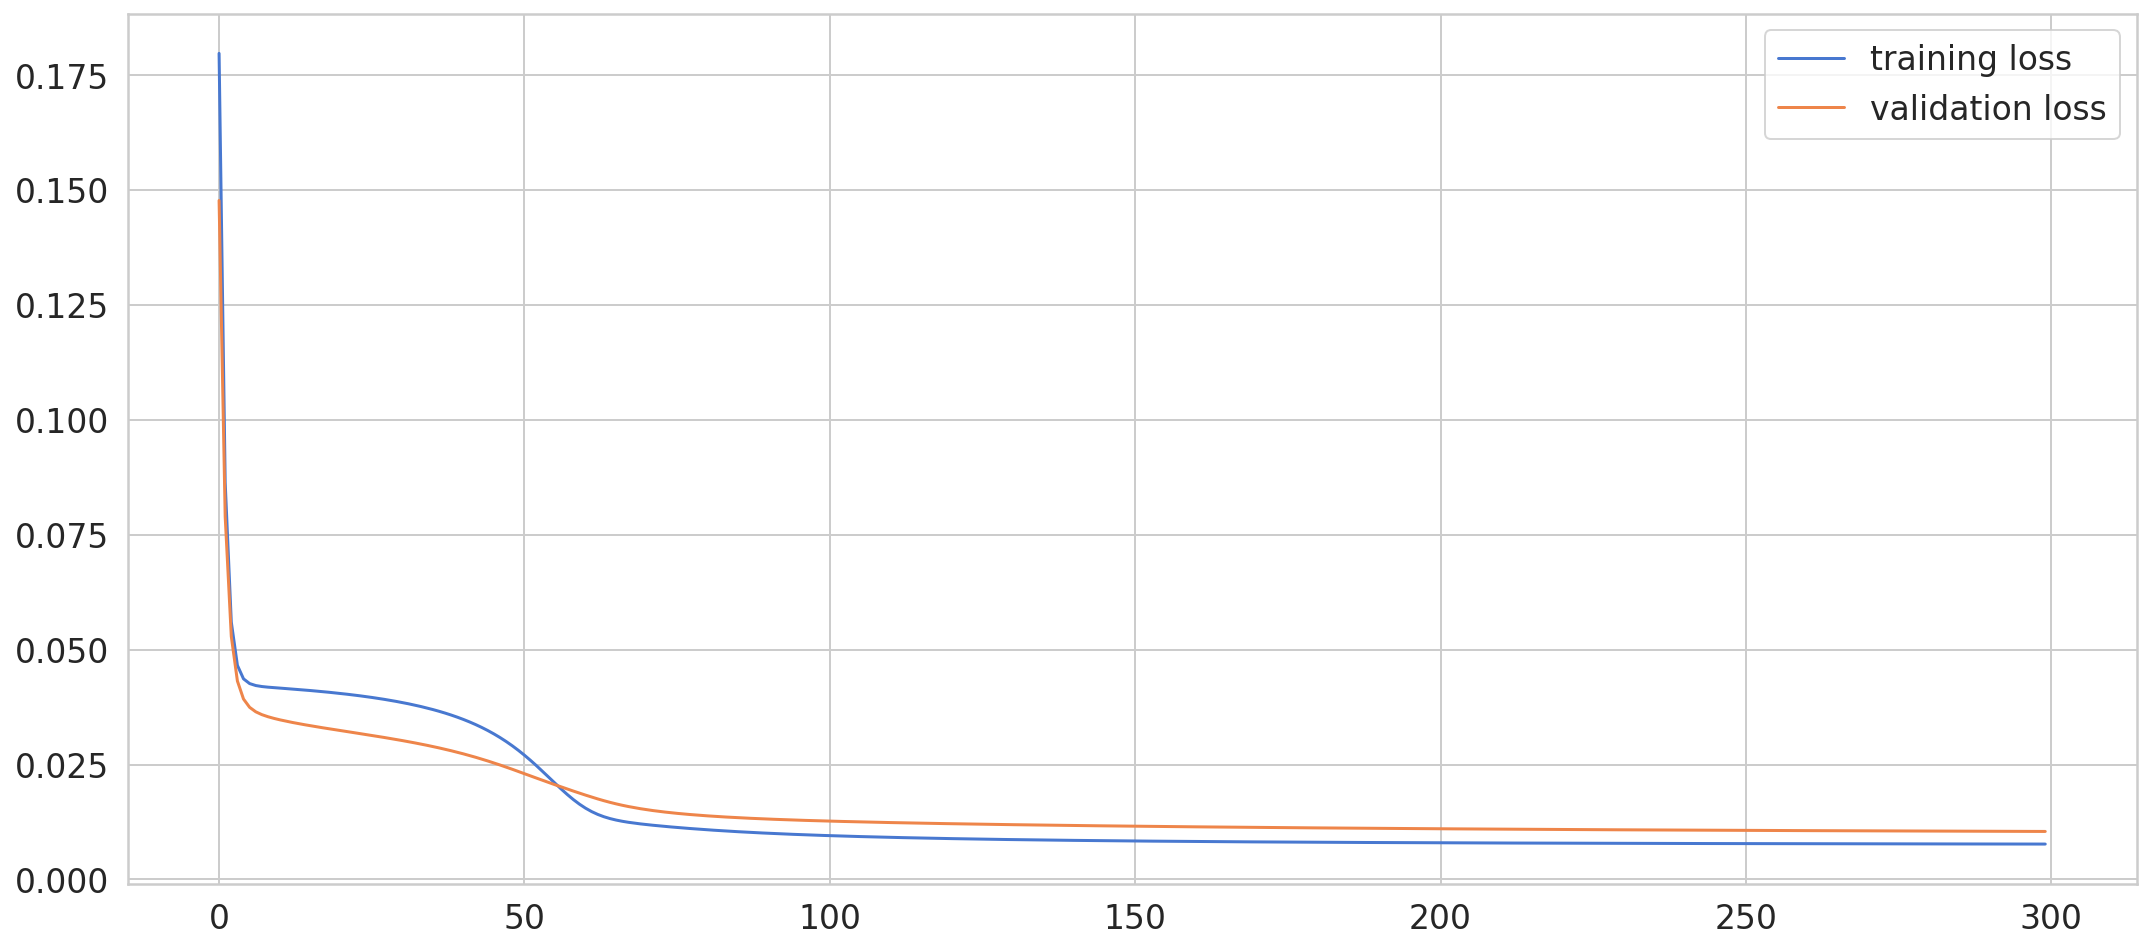

In [8]:
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

# Visualize and compare predictions

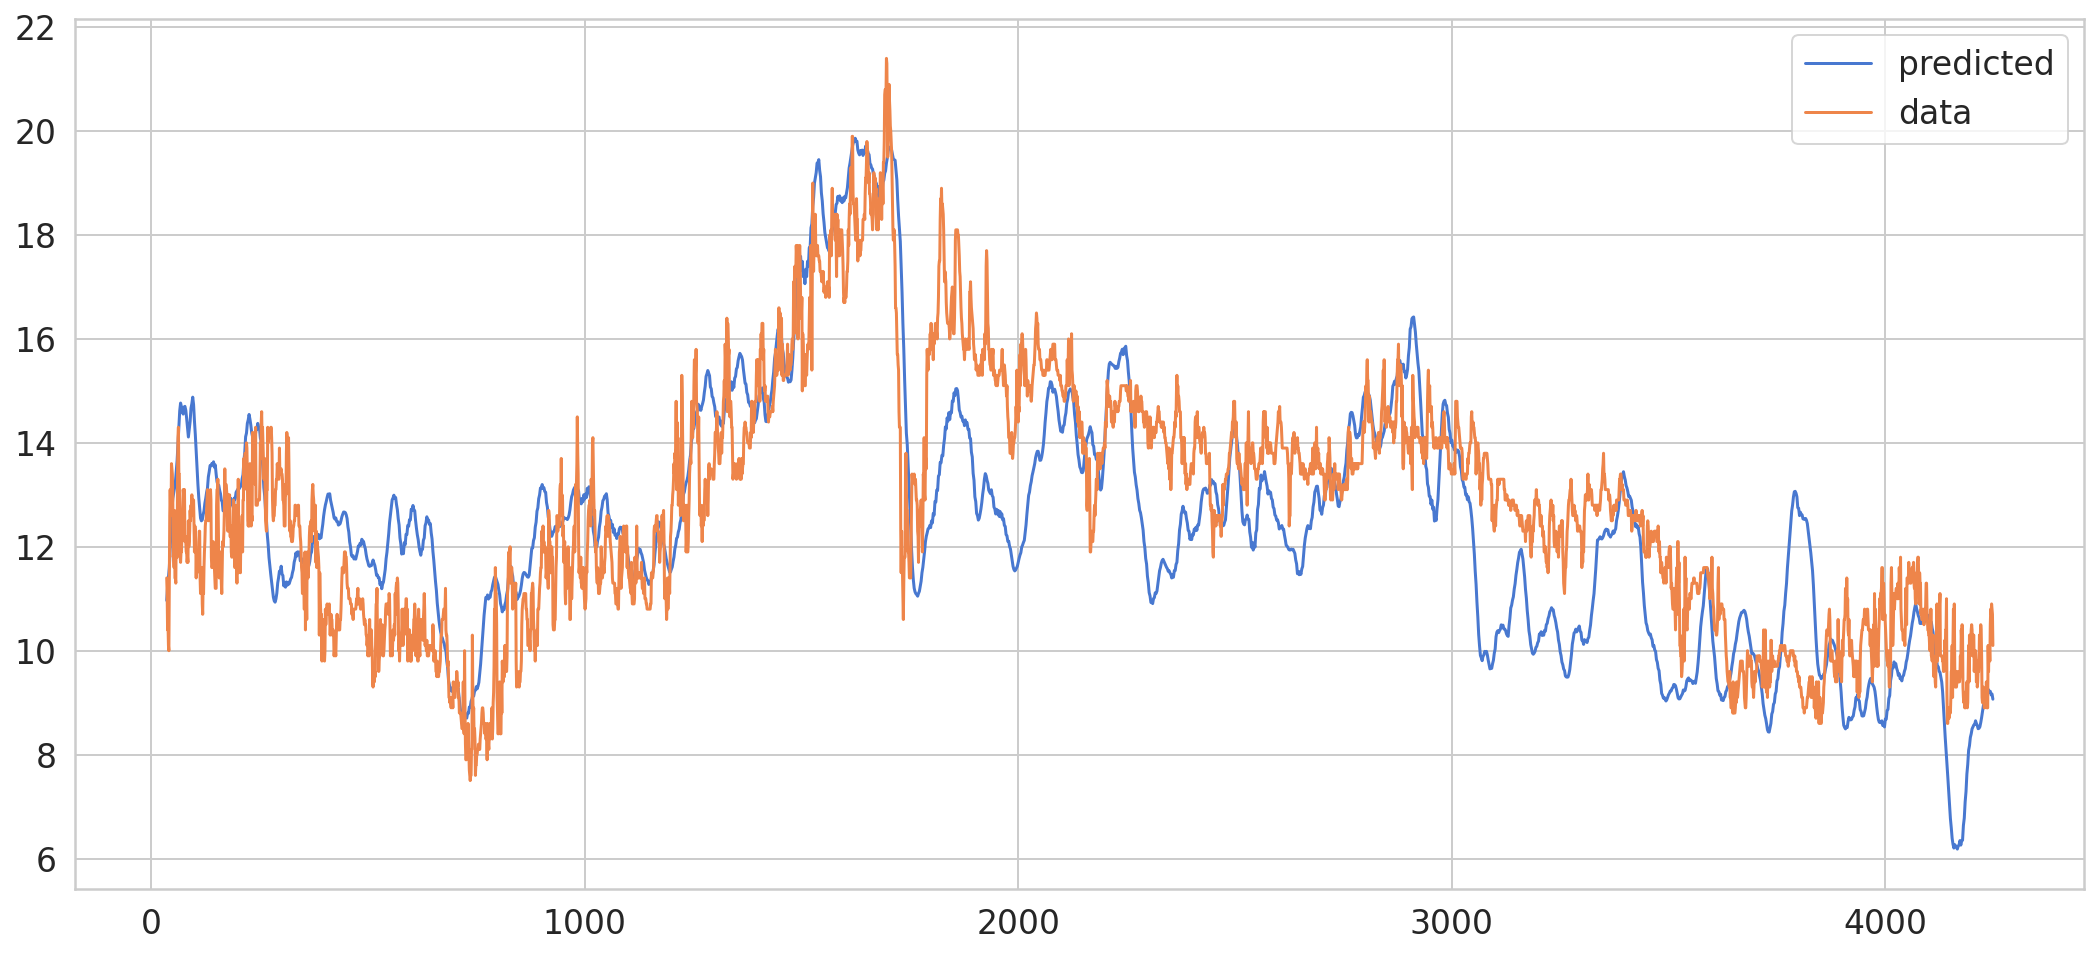

In [9]:
predy_stepped = model.predict(validx_stepped[::2, :, :])

predict_matrix = np.zeros(shape=(len(predy_stepped), 14))
predict_matrix[:,0] = predy_stepped[:,0]
predy_stepped = scaler.inverse_transform(predict_matrix)

valid_matrix = np.zeros(shape=(len(validy_stepped), 14))
valid_matrix[:,0] = validy_stepped
validy_stepped2 = scaler.inverse_transform(valid_matrix)
     
plt.plot(valid_time_plot_stepped[::2], predy_stepped[:, 0], label="predicted")
plt.plot(valid_time_plot_stepped, validy_stepped2[:, 0], label="data")
plt.legend()
plt.show()


In [11]:
model.save("output/model")